Module 1 .Financial Data Acquisition

In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=1102cba2ff6cb2a389a0c720c87fe1cf591f409ee68247eceb45db9b6a337faf
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [43]:
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Download TCS stock data (NSE: TCS.NS) for last 5 years
data = yf.download("TCS.NS", start="2018-01-01", end="2025-08-28")

# Reset index for easier handling
data.reset_index(inplace=True)

# Export raw data to CSV
data.to_csv("TCS_raw.csv", index=False)
print(" Data downloaded & saved as TCS_raw.csv")




/tmp/ipython-input-1819568262.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("TCS.NS", start="2018-01-01", end="2025-08-28")
[*********************100%***********************]  1 of 1 completed

 Data downloaded & saved as TCS_raw.csv


In [3]:
data.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
0,2018-01-01,1176.523315,1198.402998,1171.809352,1192.844130,1351760
1,2018-01-02,1170.118774,1187.195672,1165.226973,1182.926421,1920290
2,2018-01-03,1173.432007,1186.928976,1170.118945,1170.474734,1257120
3,2018-01-04,1181.637207,1183.816239,1174.032634,1178.479727,913082
4,2018-01-05,1195.912720,1200.493249,1178.480130,1178.480130,1153706


In [4]:
data.tail()

Price,Date,Close,High,Low,Open,Volume
Ticker,,TCS.NS,TCS.NS,TCS.NS,TCS.NS,TCS.NS
1885,2025-08-20,3098.600098,3103.399902,3010.899902,3010.899902,4952358
1886,2025-08-21,3102.600098,3130.000000,3083.100098,3130.000000,3230726
1887,2025-08-22,3054.000000,3095.699951,3050.000000,3086.000000,1593791
1888,2025-08-25,3140.600098,3152.000000,3077.100098,3087.300049,3448370
1889,2025-08-26,3157.199951,3162.000000,3120.000000,3129.000000,5522097


In [5]:
# Flatten MultiIndex columns
data.columns = [col[0] for col in data.columns]


In [6]:
data.head()

,Date,Close,High,Low,Open,Volume
0,2018-01-01,1176.523315,1198.402998,1171.809352,1192.844130,1351760
1,2018-01-02,1170.118774,1187.195672,1165.226973,1182.926421,1920290
2,2018-01-03,1173.432007,1186.928976,1170.118945,1170.474734,1257120
3,2018-01-04,1181.637207,1183.816239,1174.032634,1178.479727,913082
4,2018-01-05,1195.912720,1200.493249,1178.480130,1178.480130,1153706


Module 2.Data Cleaning & Feature Engineering

In [7]:
data.isnull().sum()

,0
Date,0
Close,0
High,0
Low,0
Open,0
Volume,0


**2.1 If find missing value (Handling missing value)**

In [8]:
# Forward-fill then back-fill for missing values
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

print("\nMissing values after cleaning:")
print(data.isnull().sum())


Missing values after cleaning:
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


/tmp/ipython-input-2957152918.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/tmp/ipython-input-2957152918.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1890 non-null   datetime64[ns]
 1   Close   1890 non-null   float64       
 2   High    1890 non-null   float64       
 3   Low     1890 non-null   float64       
 4   Open    1890 non-null   float64       
 5   Volume  1890 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 88.7 KB


In [10]:
data.describe()

,Date,Close,High,Low,Open,Volume
count,1890,1890.000000,1890.000000,1890.000000,1890.000000,1.890000e+03
mean,2021-10-30 13:13:08.571428352,2819.207308,2847.174678,2792.323880,2820.289261,2.827761e+06
min,2018-01-01 00:00:00,1170.118774,1183.816239,1165.226973,1170.474734,0.000000e+00
25%,2019-12-06 18:00:00,1947.145996,1972.417473,1924.727078,1947.267369,1.744290e+06
50%,2021-10-30 12:00:00,3056.018677,3083.134123,3025.500000,3052.072378,2.375210e+06
75%,2023-09-25 18:00:00,3430.239197,3460.708206,3403.545261,3433.045624,3.263649e+06
max,2025-08-26 00:00:00,4476.749512,4514.598506,4435.705272,4498.623077,8.806715e+07
std,NaN,843.544411,849.280905,838.568367,843.800368,2.625130e+06


In [11]:
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

**plot outliers for numerical columns value**

In [12]:
def plot_boxplot(data,column_name):

  plt.figure(figsize=(5,3))
  sns.boxplot(y=data[column_name])
  plt.title(f"Box plot of {column_name}")
  plt.ylabel(column_name)
  plt.show()

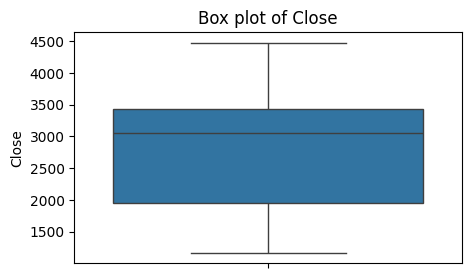

In [13]:
plot_boxplot(data,"Close")

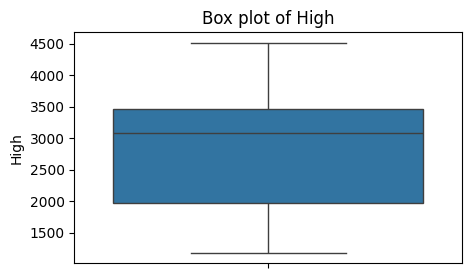

In [14]:
plot_boxplot(data,'High')

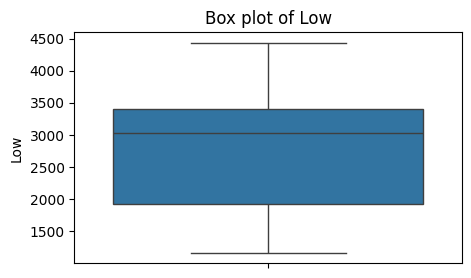

In [15]:
plot_boxplot(data,'Low')

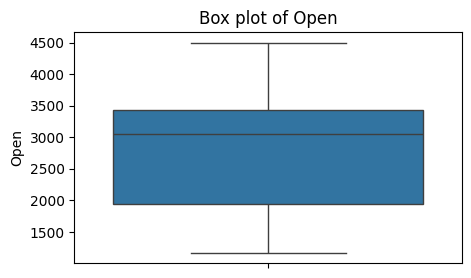

In [16]:
plot_boxplot(data,'Open')

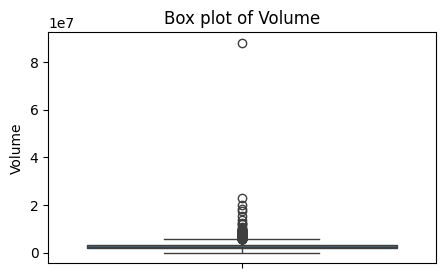

In [17]:
plot_boxplot(data,'Volume')

 **2.2 Handling Outliers (IQR Method)**

In [18]:
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    data[column] = data[column].clip(lower=lower, upper=upper) # Removed axis argument

# Apply outlier handling on key price columns
for col in [('Open'), ('High'), ('Low'), ('Close'),('Volume')]: # Using correct MultiIndex column names
    remove_outliers_iqr(data, col)

print("Outliers handled using IQR method.")

Outliers handled using IQR method.


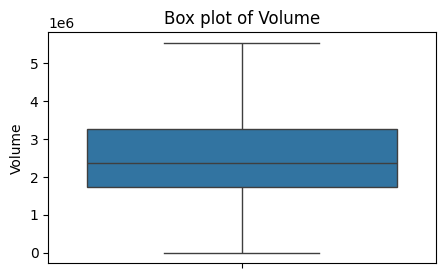

In [19]:
plot_boxplot(data,"Volume")

In [20]:
data.head()

,Date,Close,High,Low,Open,Volume
0,2018-01-01,1176.523315,1198.402998,1171.809352,1192.844130,1351760.0
1,2018-01-02,1170.118774,1187.195672,1165.226973,1182.926421,1920290.0
2,2018-01-03,1173.432007,1186.928976,1170.118945,1170.474734,1257120.0
3,2018-01-04,1181.637207,1183.816239,1174.032634,1178.479727,913082.0
4,2018-01-05,1195.912720,1200.493249,1178.480130,1178.480130,1153706.0


In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1890 entries, 0 to 1889
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1890 non-null   datetime64[ns]
 1   Close   1890 non-null   float64       
 2   High    1890 non-null   float64       
 3   Low     1890 non-null   float64       
 4   Open    1890 non-null   float64       
 5   Volume  1890 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 88.7 KB


**2.3 Feature Engineering**

In [22]:
# Moving Averages
data['SMA_10'] = data[('Close')].rolling(window=10).mean()
data['SMA_50'] = data[('Close')].rolling(window=50).mean()
data['EMA_20'] = data[('Close')].ewm(span=20, adjust=False).mean()

# Relative Strength Index (RSI)
data['RSI'] = ta.momentum.RSIIndicator(data[('Close')], window=14).rsi()

**2.4 Save Cleaned & Enhanced Data**

In [23]:

data.to_csv("TCS_cleaned_features.csv", index=False)
print("\n Cleaned & Feature engineered data saved as TCS_cleaned_features.csv")


 Cleaned & Feature engineered data saved as TCS_cleaned_features.csv


In [24]:
data.head()

,Date,Close,High,Low,Open,Volume,SMA_10,SMA_50,EMA_20,RSI
0,2018-01-01,1176.523315,1198.402998,1171.809352,1192.844130,1351760.0,NaN,NaN,1176.523315,NaN
1,2018-01-02,1170.118774,1187.195672,1165.226973,1182.926421,1920290.0,NaN,NaN,1175.913359,NaN
2,2018-01-03,1173.432007,1186.928976,1170.118945,1170.474734,1257120.0,NaN,NaN,1175.677040,NaN
3,2018-01-04,1181.637207,1183.816239,1174.032634,1178.479727,913082.0,NaN,NaN,1176.244675,NaN
4,2018-01-05,1195.912720,1200.493249,1178.480130,1178.480130,1153706.0,NaN,NaN,1178.117822,NaN


In [25]:
# Forward-fill then back-fill for missing values
data.fillna(method='ffill', inplace=True)
data.fillna(method='bfill', inplace=True)

print("\nMissing values after cleaning:")
print(data.isnull().sum())


Missing values after cleaning:
Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
SMA_10    0
SMA_50    0
EMA_20    0
RSI       0
dtype: int64


/tmp/ipython-input-2957152918.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/tmp/ipython-input-2957152918.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [26]:
data.head()

,Date,Close,High,Low,Open,Volume,SMA_10,SMA_50,EMA_20,RSI
0,2018-01-01,1176.523315,1198.402998,1171.809352,1192.844130,1351760.0,1203.321362,1315.513311,1176.523315,82.543485
1,2018-01-02,1170.118774,1187.195672,1165.226973,1182.926421,1920290.0,1203.321362,1315.513311,1175.913359,82.543485
2,2018-01-03,1173.432007,1186.928976,1170.118945,1170.474734,1257120.0,1203.321362,1315.513311,1175.677040,82.543485
3,2018-01-04,1181.637207,1183.816239,1174.032634,1178.479727,913082.0,1203.321362,1315.513311,1176.244675,82.543485
4,2018-01-05,1195.912720,1200.493249,1178.480130,1178.480130,1153706.0,1203.321362,1315.513311,1178.117822,82.543485


 **2.5 Visualization Examples**

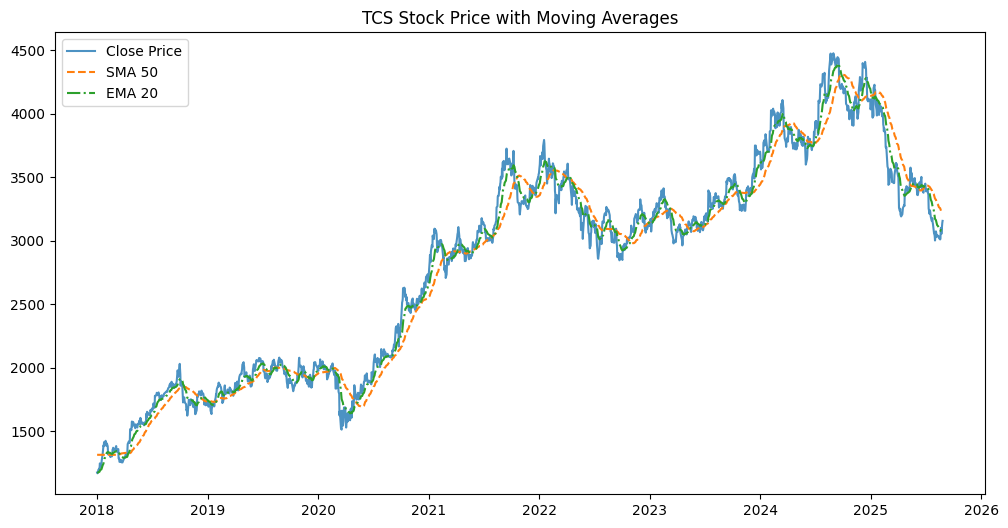

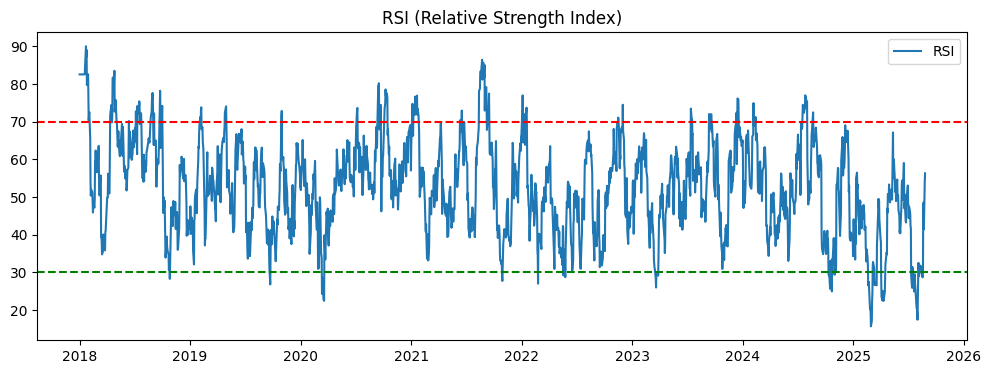

In [27]:

plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label='Close Price', alpha=0.8)
plt.plot(data['Date'], data['SMA_50'], label='SMA 50', linestyle='--')
plt.plot(data['Date'], data['EMA_20'], label='EMA 20', linestyle='-.')
plt.title("TCS Stock Price with Moving Averages")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(data['Date'], data['RSI'], label='RSI')
plt.axhline(70, color='red', linestyle='--')
plt.axhline(30, color='green', linestyle='--')
plt.title("RSI (Relative Strength Index)")
plt.legend()
plt.show()

Heat map

In [28]:
data.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'SMA_50',
       'EMA_20', 'RSI'],
      dtype='object')

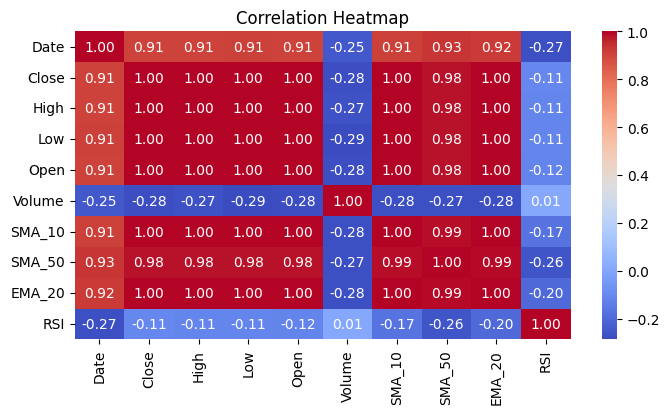

In [29]:
#correlation matrix-heatmap
plt.figure(figsize=(8,4))
sns.heatmap(data[["Date","Close","High","Low","Open","Volume","SMA_10","SMA_50","EMA_20","RSI"]].corr(),annot=True,cmap="coolwarm",fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

Train and test the model

In [30]:
from datetime import datetime

data['Date'] = pd.to_datetime(data['Date'])   # ensure datetime format
data['Date_ordinal'] = data['Date'].map(datetime.toordinal)

print(data[['Date', 'Date_ordinal']].head())

        Date  Date_ordinal
0 2018-01-01        736695
1 2018-01-02        736696
2 2018-01-03        736697
3 2018-01-04        736698
4 2018-01-05        736699


In [31]:
X=data[["Date_ordinal","Close","High","Low","Open","Volume","SMA_10","SMA_50","EMA_20","RSI"]]

Y=data["Close"]

Normalize the value in common range

In [32]:
# Apply MinMax normalization on X and Y
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.values.reshape(-1, 1))

In [33]:
#X_train,X_test,Y_train,Y_test=train_test_split(X_scaled,Y_scaled,test_size=0.2,random_state=42)

In [34]:
import pickle

pickle.dump(scaler_X, open("scaler_X.pkl", "wb"))
pickle.dump(scaler_Y, open("scaler_Y.pkl", "wb"))

Models(ARIMA)

In [35]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
close_prices = data['Close']

arima_model = ARIMA(close_prices, order=(5,1,0))  # simple ARIMA
arima_fit = arima_model.fit()

In [36]:
from datetime import timedelta

last_date = data['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end="2027-12-25")

forecast = arima_fit.forecast(steps=len(future_dates))

forecast_data = pd.DataFrame({"Date": future_dates, "Forecast_ARIMA": forecast.values})

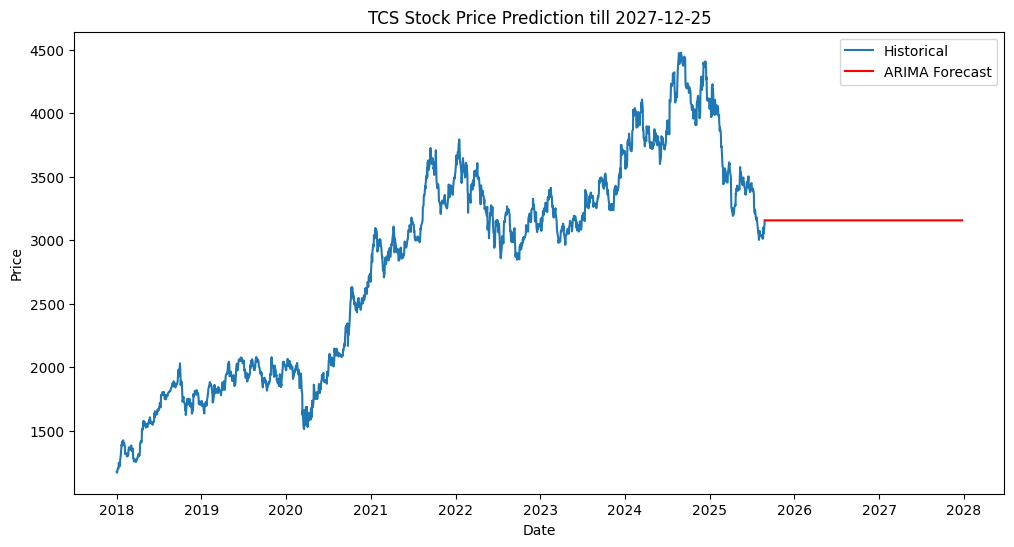

In [37]:
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label="Historical")
plt.plot(forecast_data['Date'], forecast_data['Forecast_ARIMA'], color='red', label="ARIMA Forecast")
plt.title(f"TCS Stock Price Prediction till 2027-12-25")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [38]:
import pickle

filename='stock_model_arima.pkl'
pickle.dump(arima_fit,open(filename,'wb'))

In [39]:
loaded_model=pickle.load(open(filename,'rb'))

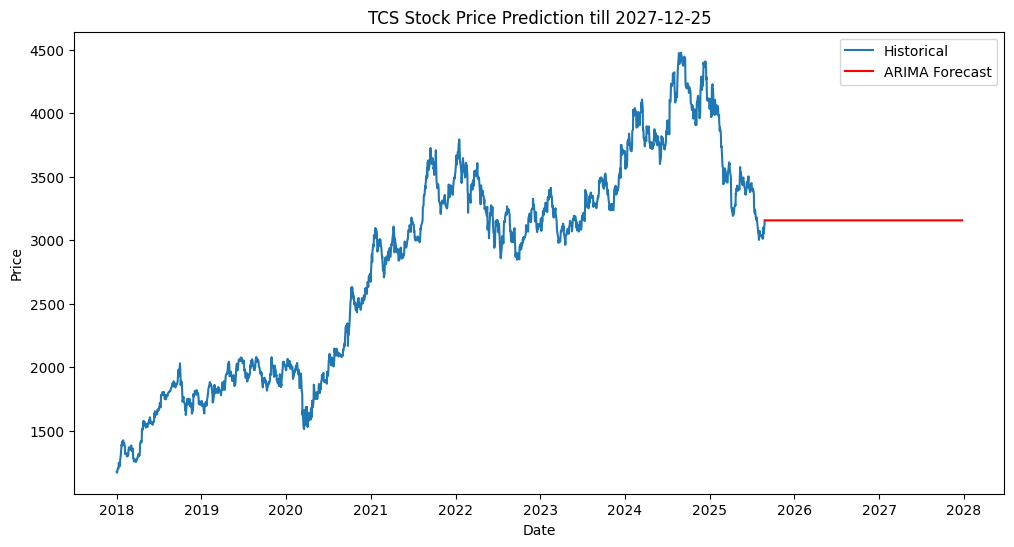

In [40]:
# Forecast into the future
last_date = data['Date'].max()
future_dates = pd.date_range(start=last_date + timedelta(days=1), end="2027-12-25")
forecast = loaded_model.forecast(steps=len(future_dates))

forecast_data = pd.DataFrame({"Date": future_dates, "Forecast_ARIMA": forecast.values})

# Plot results
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label="Historical")
plt.plot(forecast_data['Date'], forecast_data['Forecast_ARIMA'], color='red', label="ARIMA Forecast")
plt.title("TCS Stock Price Prediction till 2027-12-25")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


Model(LSTM)

1.Prepare dataset

In [42]:
# Use only Close price for LSTM prediction
close_data = data[['Close']].values

# Scale Close values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(close_data)

# Function to create sequences
import numpy as np # Import numpy
def create_sequences(dataset, time_step=60):
    X, y = [], []
    for i in range(len(dataset)-time_step-1):
        X.append(dataset[i:(i+time_step), 0])
        y.append(dataset[i+time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_sequences(scaled_close, time_step)

# Reshape for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Build LSTM Model

In [44]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)  # Output layer (predicted Close)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

Train the model

In [45]:
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    verbose=1)


Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - loss: 0.0722 - val_loss: 0.0068
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 0.0016 - val_loss: 0.0024
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 0.0

Evaluate and plot

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


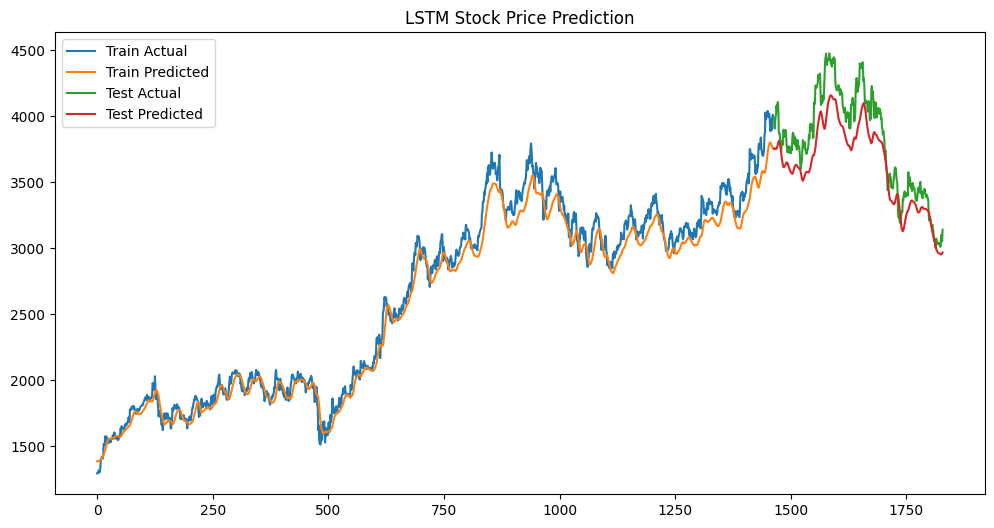

In [46]:
# Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform back to original price scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1,1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))

# Plot results
plt.figure(figsize=(12,6))
plt.plot(range(len(y_train_actual)), y_train_actual, label="Train Actual")
plt.plot(range(len(train_predict)), train_predict, label="Train Predicted")
plt.plot(range(len(y_train_actual), len(y_train_actual)+len(y_test_actual)), y_test_actual, label="Test Actual")
plt.plot(range(len(y_train_actual), len(y_train_actual)+len(test_predict)), test_predict, label="Test Predicted")
plt.legend()
plt.title("LSTM Stock Price Prediction")
plt.show()


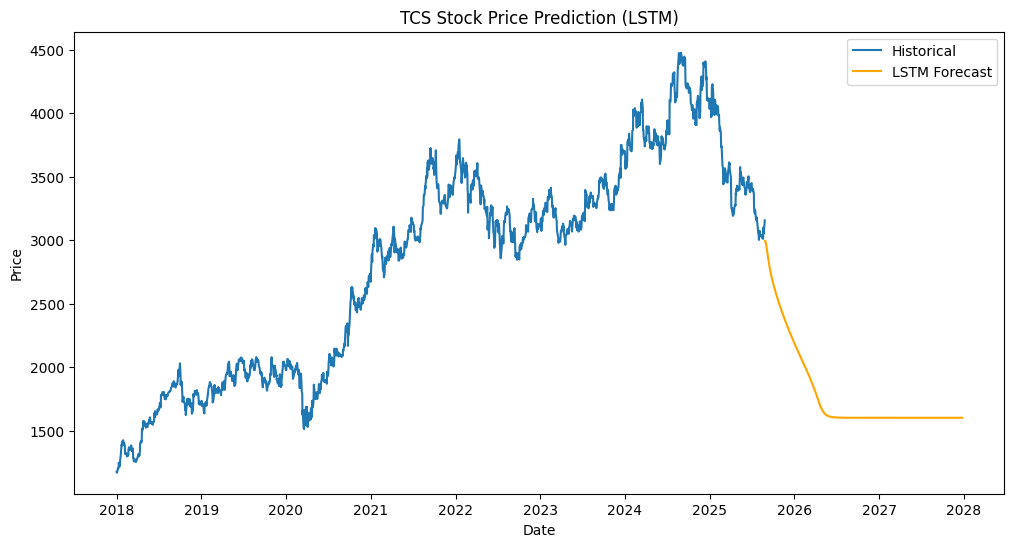

In [47]:
from datetime import timedelta
import numpy as np

# ===============================
# 1. Get the last time_step values from dataset
# ===============================
last_sequence = scaled_close[-time_step:]   # last 60 days
future_input = last_sequence.reshape(1, time_step, 1)

# ===============================
# 2. Define forecast horizon (e.g., till 2027-12-25)
# ===============================
last_date = data['Date'].max()
future_days = (pd.to_datetime("2027-12-25") - last_date).days

future_preds = []

# ===============================
# 3. Predict iteratively (autoregressive)
# ===============================
for _ in range(future_days):
    next_pred = model.predict(future_input, verbose=0)
    future_preds.append(next_pred[0,0])

    # Update sliding window (drop first, append new)
    # Reshape next_pred to match the input dimensions before appending
    next_pred_reshaped = next_pred.reshape(1, 1, 1)
    future_input = np.append(future_input[:,1:,:], next_pred_reshaped, axis=1)


# ===============================
# 4. Inverse transform to get real prices
# ===============================
future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))

# ===============================
# 5. Create future date index
# ===============================
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=future_days)

forecast_lstm = pd.DataFrame({
    "Date": future_dates,
    "Forecast_LSTM": future_preds.flatten()
})

# ===============================
# 6. Plot Historical + Future
# ===============================
plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label="Historical")
plt.plot(forecast_lstm['Date'], forecast_lstm['Forecast_LSTM'], color='orange', label="LSTM Forecast")
plt.title("TCS Stock Price Prediction (LSTM)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

In [48]:
model.save("lstm_stock_model.keras")  # modern format


In [49]:
from tensorflow.keras.models import load_model
model = load_model("lstm_stock_model.keras")
